## **Capstone Project - MLP Model**
### **Author: Neha Sharma**
### **Student Id: 23145186**

In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, f1_score
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import seaborn as sns
import time
import os
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation

In [2]:
# Load the data
from google.colab import drive

drive.mount('/content/drive')

mineral_data = pd.read_csv("/content/drive/MyDrive/Balanced_mineral_data_5000.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define the columns to remove, "x,y,yinv,Sum"
columns_to_remove = list(range(3))

# Drop the specified columns
minerals_train = mineral_data.drop(columns=mineral_data.columns[columns_to_remove])

In [4]:
minerals_train["Mineral Phase"].value_counts()

Fe-Oxide            5000
Al-Oxide            5000
AlCa-Silicate       5000
Apatite             5000
Barite              5000
Carbonate           5000
Mn-Oxide            5000
Fe-Sulphide         5000
Xenotime            5000
Background          5000
Cassiterite         5000
Fe-Sulphide_Cu      5000
Fe-sulphide_Pb      5000
Thorite             5000
W-Oxide             5000
Celestine           5000
Monazite            5000
Zircon              5000
Zn-Oxide            5000
Epidote             5000
Fe-Silicate         5000
Rutile              5000
Quartz              5000
AlK-Silicate        5000
AlFe-Silicate_Zn    5000
Columbite_Mn        5000
AlFe-Silicate       5000
Ilmenite            5000
Amphibole           5000
Titanite            5000
AlMn-Silicate       5000
Al-Silicate         5000
Chromite            5000
Leucoxene           5000
Cu-Oxide            4616
Nb-bearing phase    3735
Molybdenite         2967
REE-Silicate        2700
Name: Mineral Phase, dtype: int64

In [5]:
minerals_train.isna().sum()

CH_1                 0
CH_2                 0
CH_3                 0
CH_4                 0
CH_5                 0
                 ...  
CH_4094            159
CH_4095           1506
CH_4096          19175
Sum                  0
Mineral Phase        0
Length: 4098, dtype: int64

In [6]:
# Impute the empty columns with zero
minerals_train = minerals_train.fillna(0)

In [7]:
from sklearn.preprocessing import StandardScaler

#Split the dataset into training,validation and test sets
X = minerals_train.iloc[:, :-2]
y = minerals_train['Mineral Phase']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the training data between training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42)

# Standarize the input features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Display the shape of the data subsets
print("Training data shape:", X_train_scaled.shape)
print("Validation data shape:", X_val_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)

Training data shape: (132952, 4096)
Validation data shape: (23463, 4096)
Testing data shape: (27603, 4096)


In [8]:
onehot_encoder = OneHotEncoder(sparse_output=False)
# Sample training data
labels = np.unique(y).reshape(-1, 1)

# Convert pandas Series to NumPy arrays
y_train = y_train.to_numpy().reshape(-1, 1)
y_val = y_val.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

# Perform one-hot encoding
onehot_encoder.fit(labels)
y_train_encoded = onehot_encoder.transform(y_train)
y_val_encoded = onehot_encoder.transform(y_val)
y_test_encoded = onehot_encoder.transform(y_test)

# Inverse transform to get the original class labels
y_train_original = onehot_encoder.inverse_transform(y_train_encoded)
y_val_original = onehot_encoder.inverse_transform(y_val_encoded)
y_test_original = onehot_encoder.inverse_transform(y_test_encoded)

In [9]:
# Function to Plot training and validation loss/accuracy and learning rate
def history_plot(hist):
    plt.figure(figsize=(15, 5))
    epochs = len(hist.history['loss'])
    # Plot training and validation loss
    plt.subplot(131)
    plt.plot(hist.history['loss'], 'r-', label='Training Loss')
    plt.plot(hist.history['val_loss'], 'b-', label='Validation Loss')
    plt.xlim(0, epochs)
    plt.ylim(0, 2.2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(132)
    plt.plot(hist.history['accuracy'], 'r-', label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], 'b-', label='Validation Accuracy')
    plt.xlim(0, epochs)
    plt.ylim(0, 1.2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.legend()

    # Plot learning rate
    plt.subplot(133)
    plt.plot(hist.history['lr'], 'g-', label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# Function to display the confusion matrix for all the classifiers used in the report
sns.set(style='ticks')
def cm_display(model_name,model_pred,response_var,display_labels):
  fig, ax = plt.subplots(figsize=(18,12))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(response_var,model_pred),display_labels = display_labels)
  cm_display.plot(xticks_rotation='vertical',ax=ax)
  plt.title("\n\nConfusion matrix for %s\n"% model_name)
  plt.show()
  print('\033[1m'+"\n\nClassification report for %s \n\n"% model_name+'\033[0m',classification_report(response_var, model_pred, target_names=display_labels, zero_division=0))

In [11]:
# Define a function to create the MLP model
def create_mlp(num_layers=3,learning_rate=0.001, activation_function='swish', dropout_rate=0.4,weight_initialization='glorot_normal',num_minerals=38):
    model = Sequential()
    model.add(Dense(128, activation=activation_function,kernel_initializer=weight_initialization,input_dim=4096))
    model.add(Dropout(dropout_rate))
    model.add(Dense(96, activation=activation_function,kernel_initializer=weight_initialization))
    model.add(Dropout(0.3))
    if (num_layers == 3):
      model.add(Dense(64, activation=activation_function,kernel_initializer=weight_initialization))
      model.add(Dropout(0.3))

    # Output Layers
    model.add(Dense(num_minerals, activation='softmax',kernel_initializer=weight_initialization))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Define performance-based learning rate scheduling
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5)

mlp_model = create_mlp()

# Model Summary
mlp_model.summary()

# Start the timer
start_time_mlp = time.time()

# Fit the training data
history_mlp = mlp_model.fit(X_train_scaled, y_train_encoded, validation_data=(X_val_scaled, y_val_encoded), batch_size=32, epochs=100,
                          callbacks=[early_stopping,ModelCheckpoint("mlp", save_best_only=True),lr_schedule])

# Stop the timer and calculate the model training time
end_time_mlp = time.time()
training_time_mlp = (end_time_mlp - start_time_mlp) / 60

# Save the model in TensorFlow save model format
mlp_model.save("/content/drive/MyDrive/caps_mlp_model", save_format='tf')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               524416    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 96)                12384     
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                6208      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 38)                2

Computation time for a MLP model is 4.90 minutes





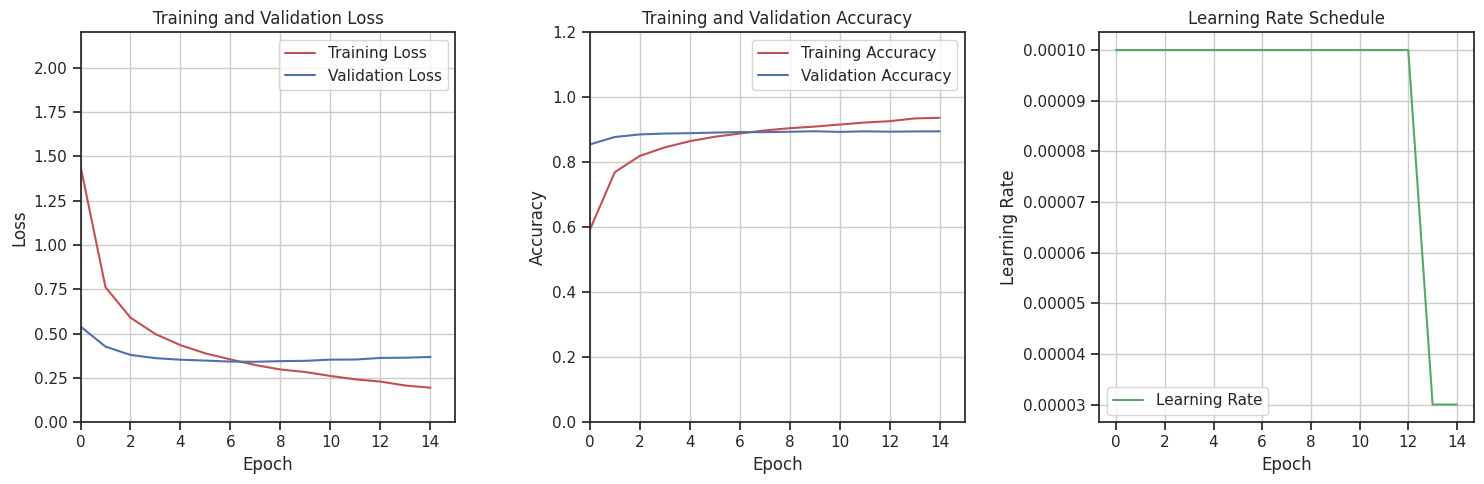

In [13]:
print(f"Computation time for a MLP model is {training_time_mlp:.2f} minutes\n\n\n")

# Plot the training history
history_plot(history_mlp)

In [14]:
# Obtain the prediction
mlp_train_predict = mlp_model.predict(X_train_scaled, verbose=0)
mlp_test_predict = mlp_model.predict(X_test_scaled, verbose=0)

# Calculate the accuracy on training and test set
mlp_train_accuracy = accuracy_score(np.argmax(y_train_encoded, axis=1), np.argmax(mlp_train_predict, axis=1))
mlp_test_accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), np.argmax(mlp_test_predict, axis=1))

In [15]:
print('\033[1m'+"\n\nAccuracy on Training set: "+'\033[0m'+"{:.2f}".format(mlp_train_accuracy * 100),"\n\n")

print('\033[1m'+"\n\nAccuracy on Testing set: "+'\033[0m'+"{:.2f}".format(mlp_test_accuracy * 100),"\n\n")



Accuracy on Training set: 95.15 




Accuracy on Testing set: 89.61 




In [16]:
# Get the mapping from encoded values to labels
encoded_to_labels = onehot_encoder.categories_[0]

# Create a class_names list
class_names = list(encoded_to_labels)

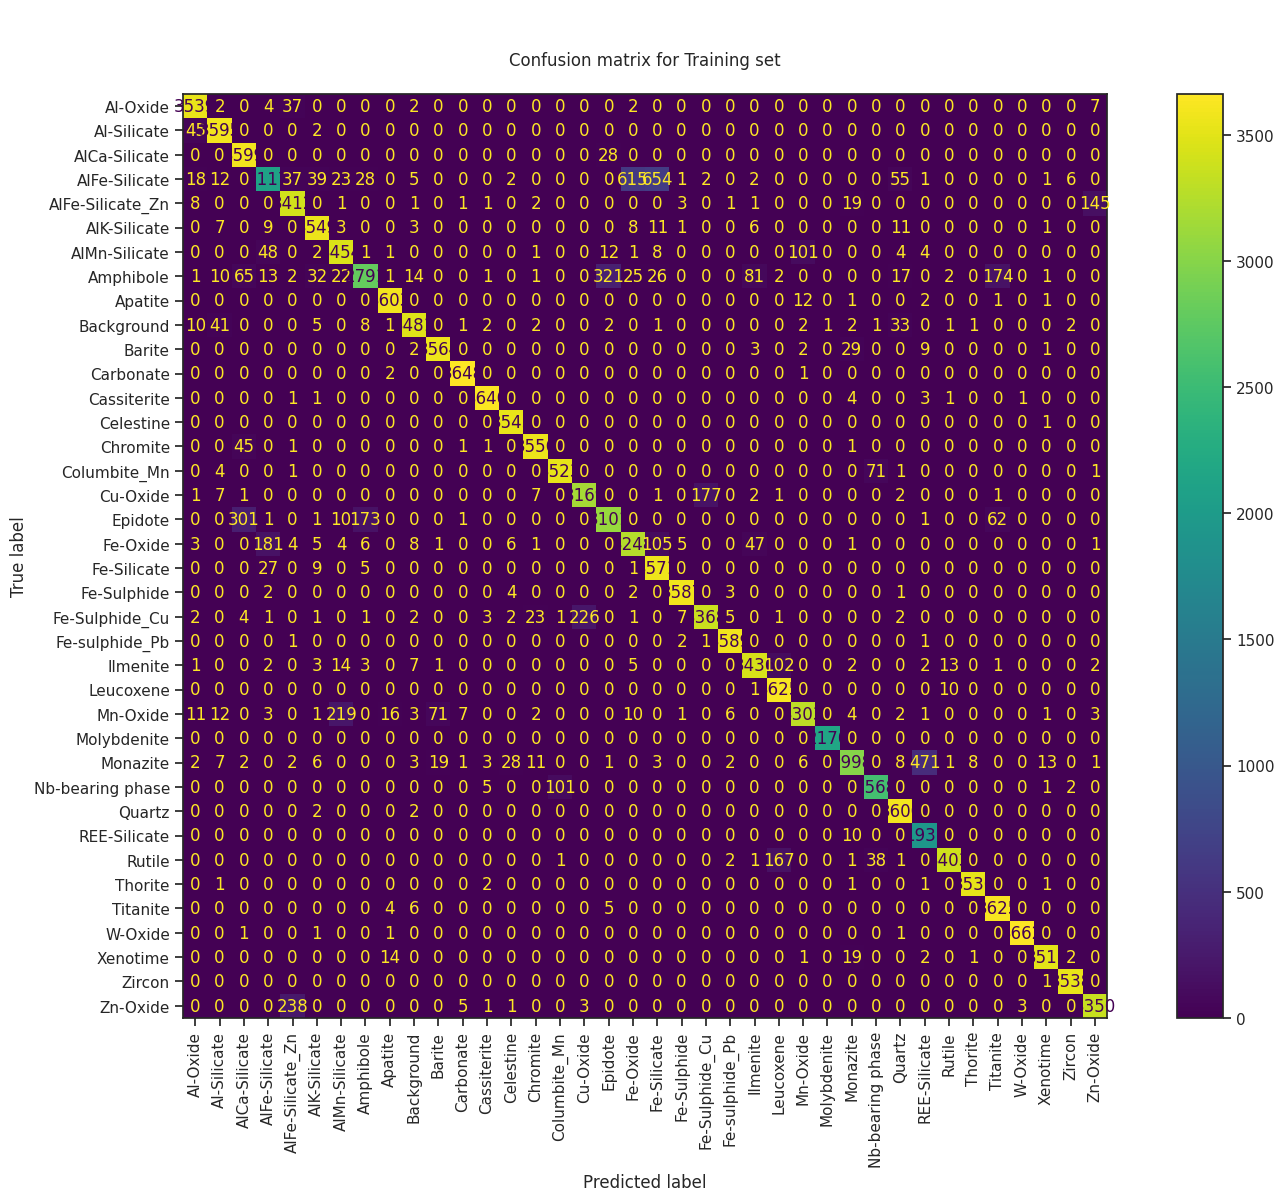



Classification report for Training set 

                   precision    recall  f1-score   support

        Al-Oxide       0.97      0.98      0.98      3593
     Al-Silicate       0.97      0.99      0.98      3642
   AlCa-Silicate       0.90      0.99      0.94      3627
   AlFe-Silicate       0.88      0.59      0.70      3618
AlFe-Silicate_Zn       0.91      0.95      0.93      3595
    AlK-Silicate       0.97      0.98      0.98      3609
   AlMn-Silicate       0.92      0.95      0.94      3637
       Amphibole       0.93      0.77      0.84      3602
         Apatite       0.99      1.00      0.99      3620
      Background       0.98      0.97      0.98      3597
          Barite       0.97      0.99      0.98      3610
       Carbonate       1.00      1.00      1.00      3651
     Cassiterite       0.99      1.00      1.00      3651
       Celestine       0.99      1.00      0.99      3544
        Chromite       0.99      0.99      0.99      3605
    Columbite_Mn       0.97

In [17]:
cm_display("Training set", np.argmax(mlp_train_predict, axis=1),np.argmax(y_train_encoded, axis=1),class_names)

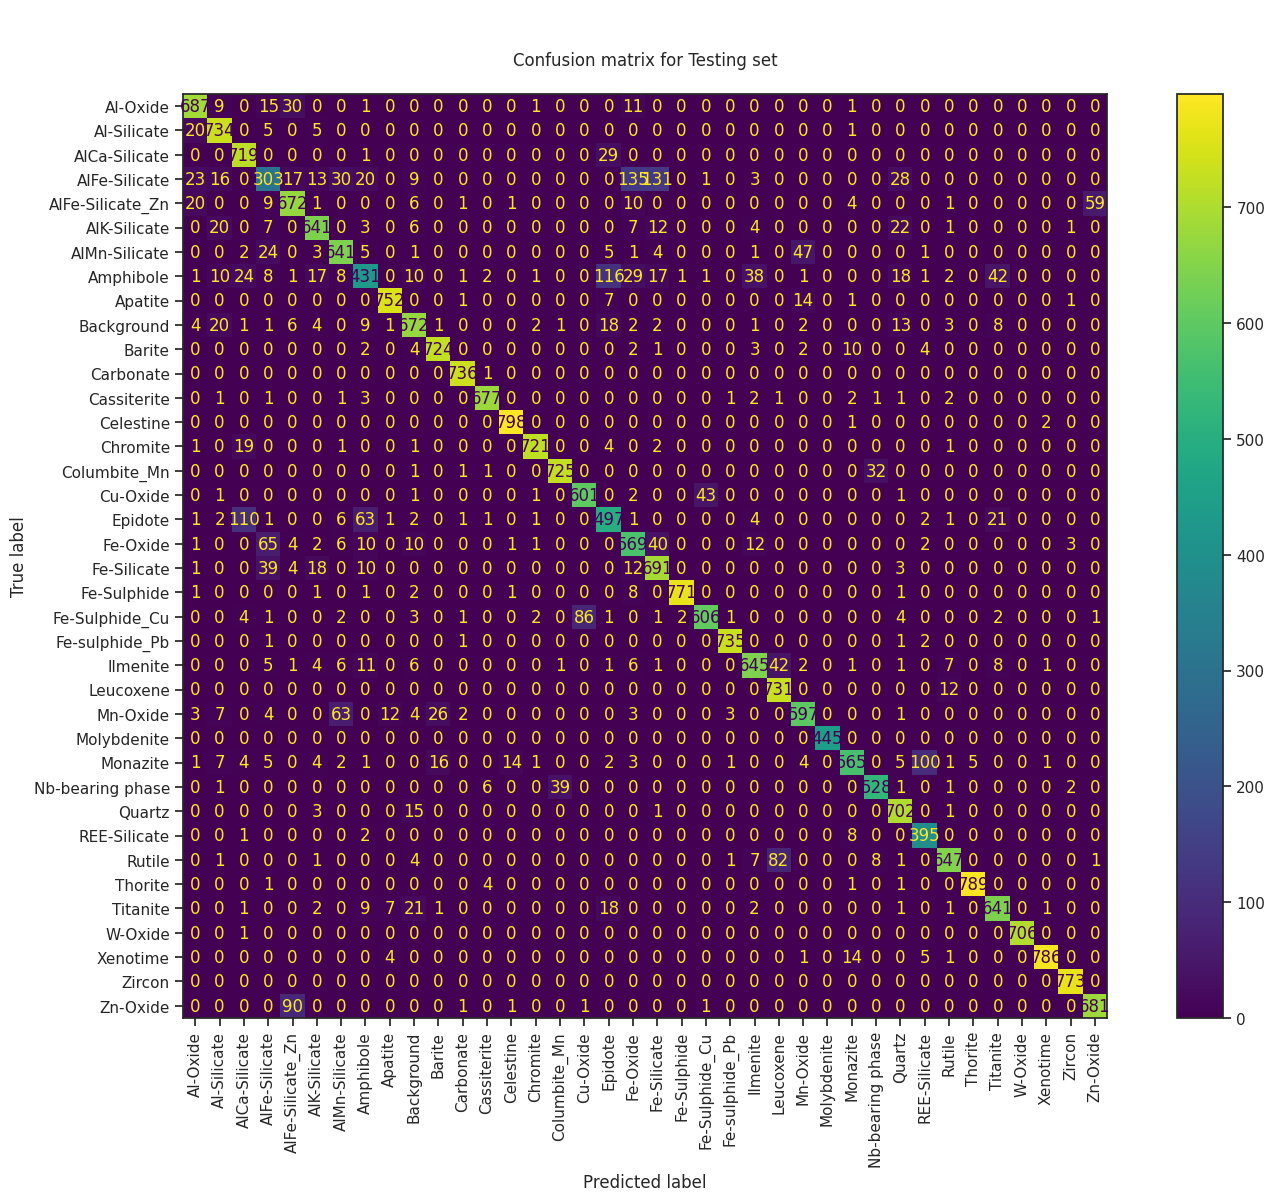



Classification report for Testing set 

                   precision    recall  f1-score   support

        Al-Oxide       0.90      0.91      0.90       755
     Al-Silicate       0.89      0.96      0.92       765
   AlCa-Silicate       0.81      0.96      0.88       749
   AlFe-Silicate       0.61      0.42      0.50       729
AlFe-Silicate_Zn       0.81      0.86      0.84       784
    AlK-Silicate       0.89      0.89      0.89       724
   AlMn-Silicate       0.84      0.87      0.85       735
       Amphibole       0.74      0.55      0.63       780
         Apatite       0.97      0.97      0.97       776
      Background       0.86      0.87      0.87       771
          Barite       0.94      0.96      0.95       752
       Carbonate       0.99      1.00      0.99       737
     Cassiterite       0.98      0.98      0.98       693
       Celestine       0.98      1.00      0.99       801
        Chromite       0.99      0.96      0.97       750
    Columbite_Mn       0.95 

In [18]:
# Create a class_names list
cm_display("Testing set", np.argmax(mlp_test_predict, axis=1),np.argmax(y_test_encoded, axis=1),class_names)

## Testing the model on the 10_combined_test_set

In [19]:
# Load the data
mineral_test_data = pd.read_csv("/content/drive/MyDrive/10_combined_shuffled.csv")

# Drop the specified columns
minerals_test = mineral_test_data.drop(columns=mineral_test_data.columns[columns_to_remove])

# Load the pre-trained labels provided by the client
pretrained_labels = minerals_train["Mineral Phase"].tolist()

# Identify categories in the test data that are not in the pre-trained labels
unknown_categories = set(minerals_test['Mineral Phase']) - set(pretrained_labels)

print("Extra lables than not resent in training set: ", unknown_categories)

# Remove the data points for the labels not present in training dataset
minerals_test = minerals_test[~minerals_test['Mineral Phase'].isin(unknown_categories)]

Extra lables than not resent in training set:  {'MgAl-Oxide', 'RM ONLY', 'Unknown', 'Fe-Sulphide_Zn', 'Tourmaline'}


In [20]:
minerals_test['Mineral Phase'].value_counts()

Fe-Oxide            7000
Background          7000
Ilmenite            5808
Epidote             5193
AlFe-Silicate       4306
Amphibole           3984
AlMn-Silicate       3864
Titanite            1768
Fe-Silicate         1229
Fe-Sulphide         1079
Rutile               611
Monazite             408
AlK-Silicate         338
Quartz               182
Zircon               179
Al-Silicate          124
AlCa-Silicate         69
Xenotime              35
Zn-Oxide              33
Chromite              22
Al-Oxide              18
Barite                15
Cassiterite           15
REE-Silicate          14
Celestine             13
Mn-Oxide              12
Leucoxene             12
AlFe-Silicate_Zn      10
Apatite                6
Thorite                2
Fe-sulphide_Pb         1
Name: Mineral Phase, dtype: int64

In [21]:
minerals_test.isna().sum()

CH_1                0
CH_2                0
CH_3                0
CH_4                0
CH_5                0
                 ... 
CH_4094             0
CH_4095             0
CH_4096          4253
Sum                 0
Mineral Phase       0
Length: 4098, dtype: int64

In [22]:
minerals_test = minerals_test.fillna(0)

In [23]:
test_x = minerals_test.iloc[:, :-2]
test_y = minerals_test['Mineral Phase']

labels = np.unique(test_y)

test_y = test_y.to_numpy().reshape(-1, 1)


test_y_encoded = onehot_encoder.transform(test_y)

# Obtain the prediction on 10_combined_test_data
test_predict = mlp_model.predict(test_x)


# Calculate the accuracy on training and test set
test_accuracy = accuracy_score(np.argmax(test_y_encoded, axis=1), np.argmax(test_predict, axis=1))
print('\033[1m'+"\n\nAccuracy on 10 combined Test set: "+'\033[0m'+"{:.2f}".format(test_accuracy * 100),"\n\n")

1355/1355 [==============================] - 3s 2ms/step


Accuracy on 10 combined Test set: 61.14 




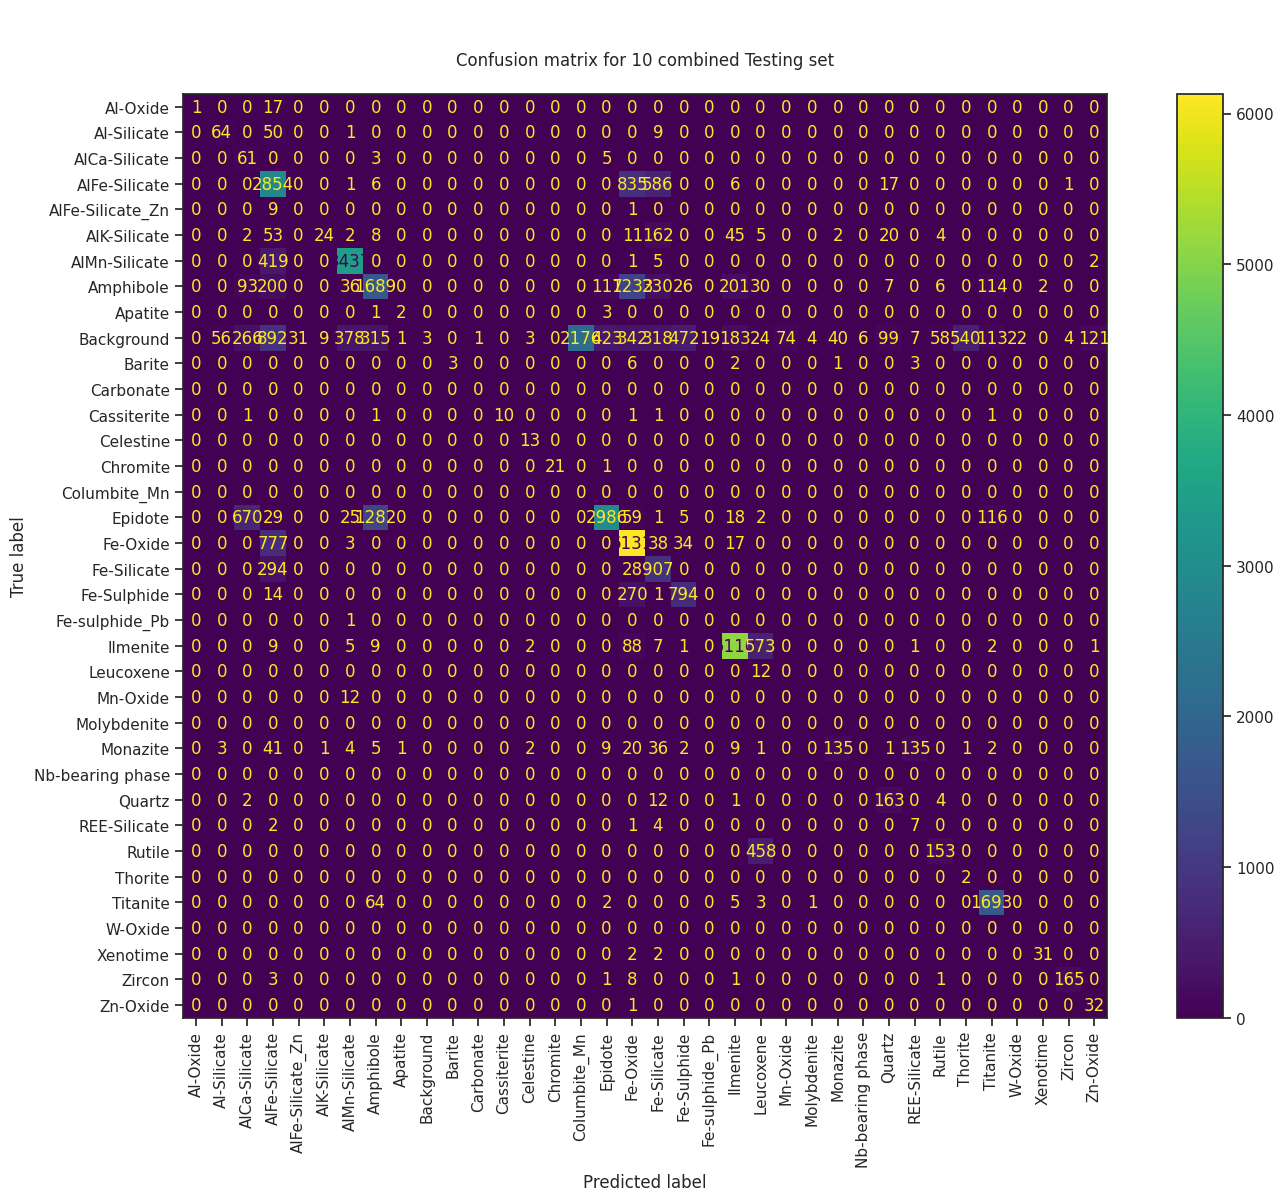



Classification report for 10 combined Testing set 

                   precision    recall  f1-score   support

        Al-Oxide       1.00      0.06      0.11        18
     Al-Silicate       0.52      0.52      0.52       124
   AlCa-Silicate       0.06      0.88      0.10        69
   AlFe-Silicate       0.50      0.66      0.57      4306
AlFe-Silicate_Zn       0.00      0.00      0.00        10
    AlK-Silicate       0.71      0.07      0.13       338
   AlMn-Silicate       0.88      0.89      0.88      3864
       Amphibole       0.50      0.42      0.46      3984
         Apatite       0.50      0.33      0.40         6
      Background       1.00      0.00      0.00      7000
          Barite       1.00      0.20      0.33        15
       Carbonate       0.00      0.00      0.00         0
     Cassiterite       1.00      0.67      0.80        15
       Celestine       0.65      1.00      0.79        13
        Chromite       1.00      0.95      0.98        22
    Columbite_Mn

In [43]:
# List of data
data = list(encoded_to_labels)

# Your list of indices to keep
classes_to_keep = list(np.unique(np.argmax(test_predict, axis=1)))

# Filter the data list to keep only items with indices present in indices_to_keep
class_names = [data[i] for i in classes_to_keep]

cm_display("10 combined Testing set", np.argmax(test_predict, axis=1),np.argmax(test_y_encoded, axis=1), class_names)